# Random Forests, GBM, XGBoost, LightGBM, CatBoost

**Import Libraries**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

C:\Users\sedat\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sedat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\sedat\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

**Read csv file**

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

## Random Forests

**First random forest model without any optimization**

In [5]:
rf_model = RandomForestClassifier(random_state=17)

In [6]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [7]:
cv_results = cross_validate(rf_model, X, y,
                           cv=10,
                           scoring=['accuracy', 'f1', 'roc_auc'])

In [8]:
cv_results['test_accuracy'].mean()

0.753896103896104

In [9]:
cv_results['test_f1'].mean()

0.6190701534636385

In [10]:
cv_results['test_roc_auc'].mean()

0.8233960113960114

**Second model after hyperparameters optimization**

In [11]:
rf_params = {'max_depth': [5, 8, None],
            'max_features': [3, 5, 7, 'auto'],
            'min_samples_split': [2, 5, 8, 15, 20],
            'n_estimators': [100, 200, 500]}

In [12]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [13]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [14]:
rf_final_model = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [15]:
rf_final_model

RandomForestClassifier(max_features=5, min_samples_split=8, n_estimators=500,
                       random_state=17)

In [16]:
cv_results = cross_validate(rf_final_model, X, y,
                           cv=10,
                           scoring=['accuracy', 'f1', 'roc_auc'])

In [17]:
cv_results['test_accuracy'].mean()

0.766848940533151

In [18]:
cv_results['test_f1'].mean()

0.6447777811143756

In [19]:
cv_results['test_roc_auc'].mean()

0.8271054131054132

**Feature Importance**

In [20]:
rf_final_model.feature_importances_

array([0.06223598, 0.34167965, 0.07365977, 0.04363433, 0.04935195,
       0.17717429, 0.1185577 , 0.13370633])

In [21]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

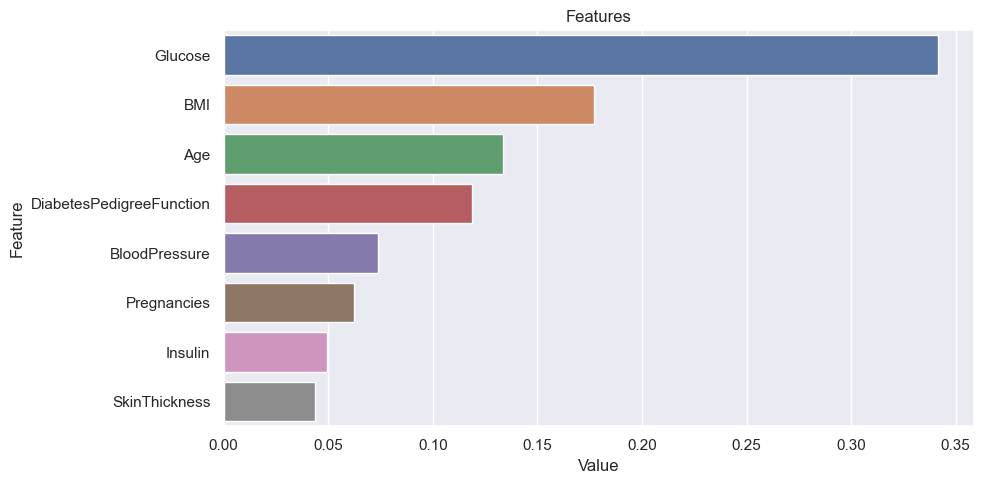

In [22]:
plot_importance(rf_final_model, X)

**Learning Curve**

In [23]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

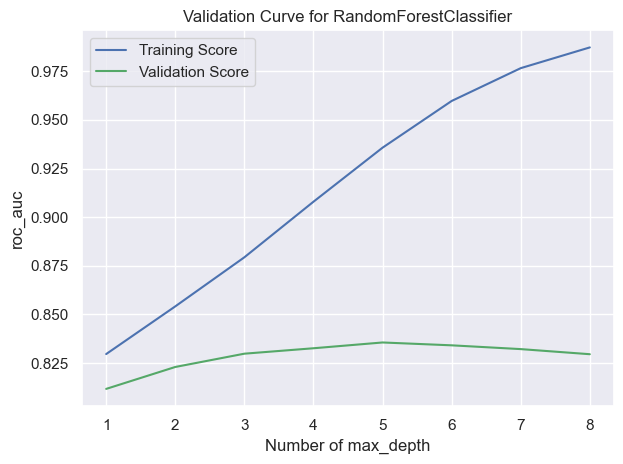

In [24]:
val_curve_params(rf_final_model, X, y, 'max_depth', range(1, 9), scoring='roc_auc')

## Gradient Boosting Machine (GBM)

**First model without hyperparameter optimization**

In [25]:
gbm_model = GradientBoostingClassifier(random_state=17)

In [26]:
gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [27]:
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [28]:
cv_results['test_accuracy'].mean()

0.7591715474068416

In [29]:
cv_results['test_f1'].mean()

0.634235802826363

In [30]:
cv_results['test_roc_auc'].mean()

0.8254867225716283

**Hyperparameter optimization**

In [31]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [32]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [33]:
gbm_best_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}

In [34]:
gbm_final_model = gbm_model.set_params(**gbm_best_grid.best_params_).fit(X, y)

In [35]:
cv_results = cross_validate(gbm_final_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [36]:
cv_results['test_accuracy'].mean()

0.7800186741363212

In [37]:
cv_results['test_f1'].mean()

0.668605747317776

In [38]:
cv_results['test_roc_auc'].mean()

0.8257784765897973

## XGBoost

**First model without hyperparameter optimization**

In [39]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)

In [40]:
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [41]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [42]:
cv_results['test_accuracy'].mean()

0.7526525761819879

In [43]:
cv_results['test_f1'].mean()

0.6317893713482235

In [44]:
cv_results['test_roc_auc'].mean()

0.7987134870719776

**Hyperparameter optimization**

In [45]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.5, 0.7, 1]}

In [46]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [47]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [48]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [49]:
cv_results['test_accuracy'].mean()

0.7630591630591631

In [50]:
cv_results['test_f1'].mean()

0.6371383000513445

In [51]:
cv_results['test_roc_auc'].mean()

0.8223626834381552

## LightGBM

**First model without hyperparameter optimization**

In [52]:
lgm_model = LGBMClassifier(random_state=17)

In [53]:
lgm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [54]:
cv_results = cross_validate(lgm_model, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])

In [55]:
cv_results['test_accuracy'].mean()

0.7474492827434004

In [56]:
cv_results['test_f1'].mean()

0.624110522144179

In [57]:
cv_results['test_roc_auc'].mean()

0.7990293501048218

**Hyperparameter optimization**

In [58]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [59]:
lgbm_best_grid = GridSearchCV(lgm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [60]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}

In [61]:
lgbm_final_model = lgm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [62]:
cv_results = cross_validate(lgbm_final_model, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])

In [63]:
cv_results['test_accuracy'].mean()

0.7643578643578645

In [64]:
cv_results['test_f1'].mean()

0.6372062920577772

In [65]:
cv_results['test_roc_auc'].mean()

0.8147491264849755

**Optimization only n_estimator**

In [66]:
lgm_model = LGBMClassifier(random_state=17, colsample_bytree=1, learning_rate=0.01)

In [67]:
lgbm_params = {"n_estimators": [100, 300, 500, 1000, 5000, 10000]}

In [68]:
lgbm_best_grid = GridSearchCV(lgm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [69]:
lgbm_best_grid.best_params_

{'n_estimators': 300}

## CatBoosting

**First model without hyperparameter optimization**

In [70]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

In [71]:
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [72]:
cv_results['test_accuracy'].mean()

0.7735251676428148

In [73]:
cv_results['test_f1'].mean()

0.6502723851348231

In [74]:
cv_results['test_roc_auc'].mean()

0.8378923829489867

**Hyperparameter optimization**

In [75]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [76]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [77]:
catboost_best_grid.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.01}

In [78]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [79]:
cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [80]:
cv_results['test_accuracy'].mean()

0.7721755368814192

In [81]:
cv_results['test_f1'].mean()

0.6322580676028952

In [82]:
cv_results['test_roc_auc'].mean()

0.842001397624039

## Feature Importance

In [83]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 5))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title(f'Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

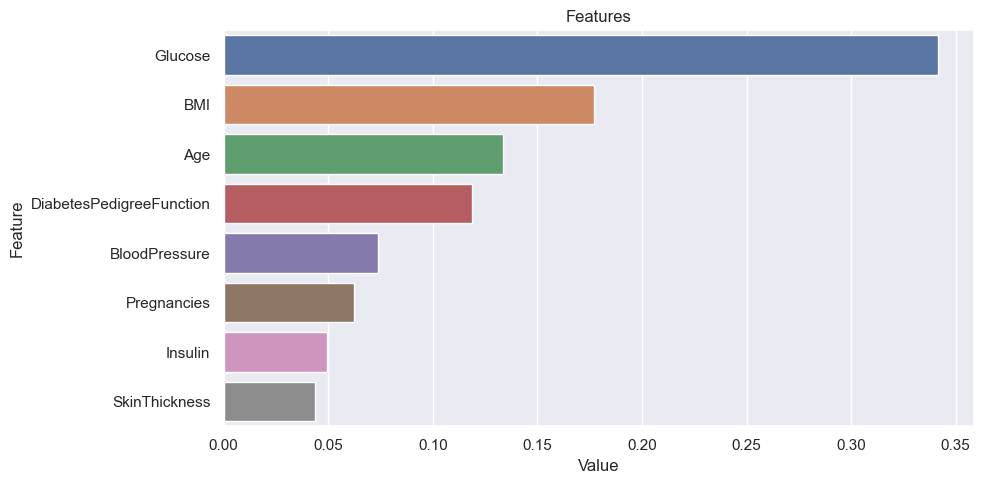

In [84]:
plot_importance(rf_final_model, X)

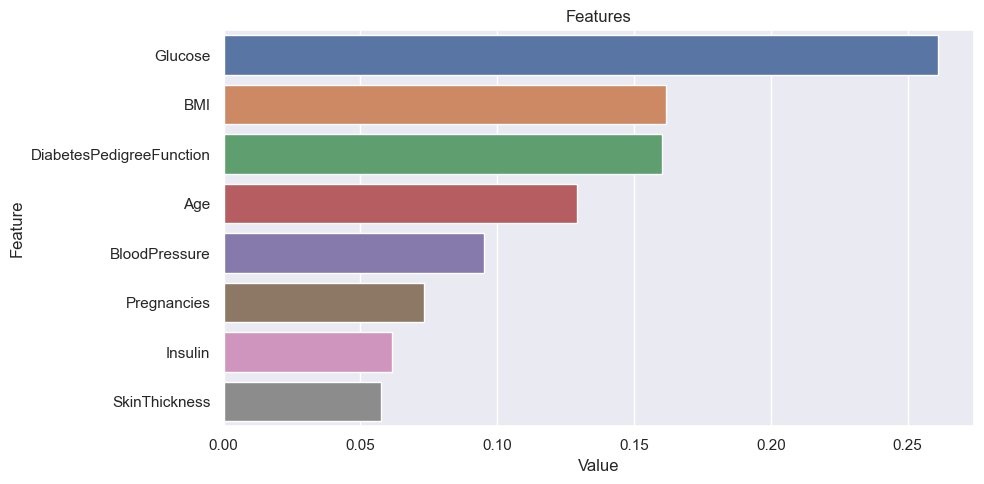

In [85]:
plot_importance(gbm_final_model, X)

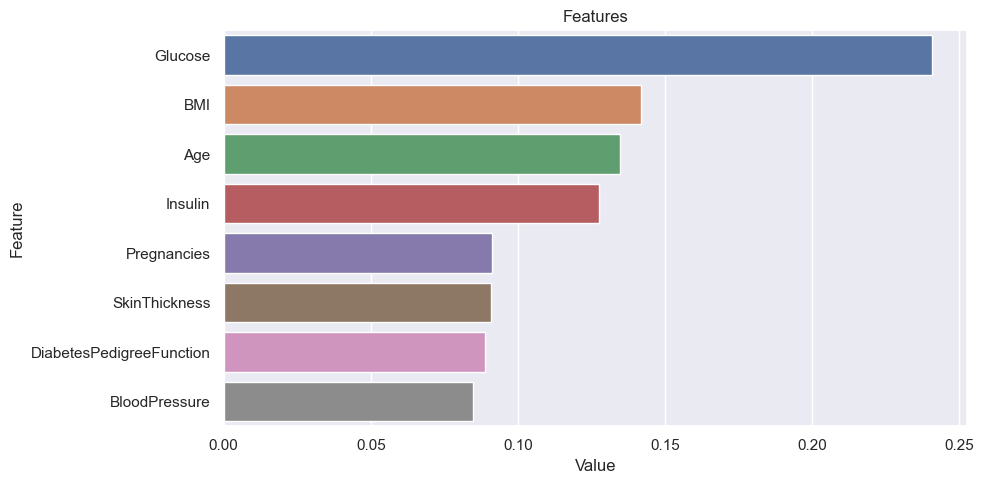

In [86]:
plot_importance(xgboost_final, X)

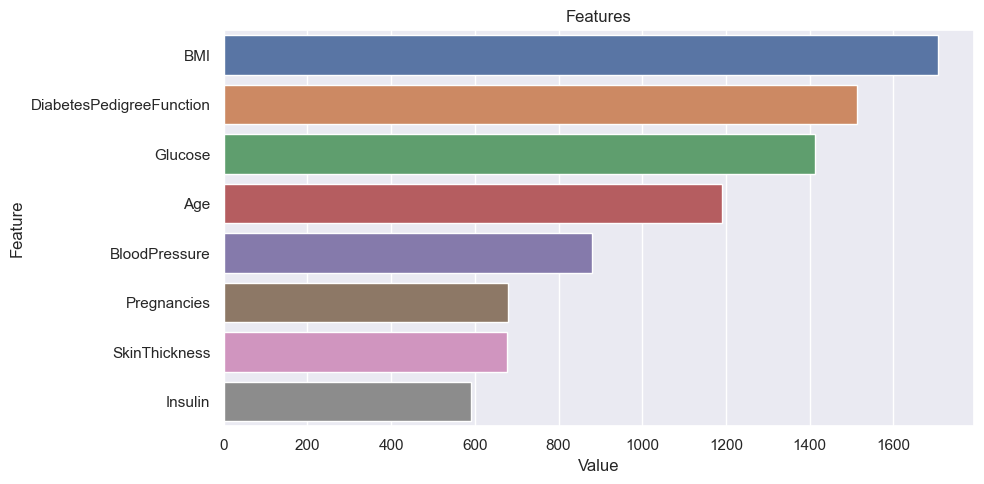

In [87]:
plot_importance(lgbm_final_model, X)

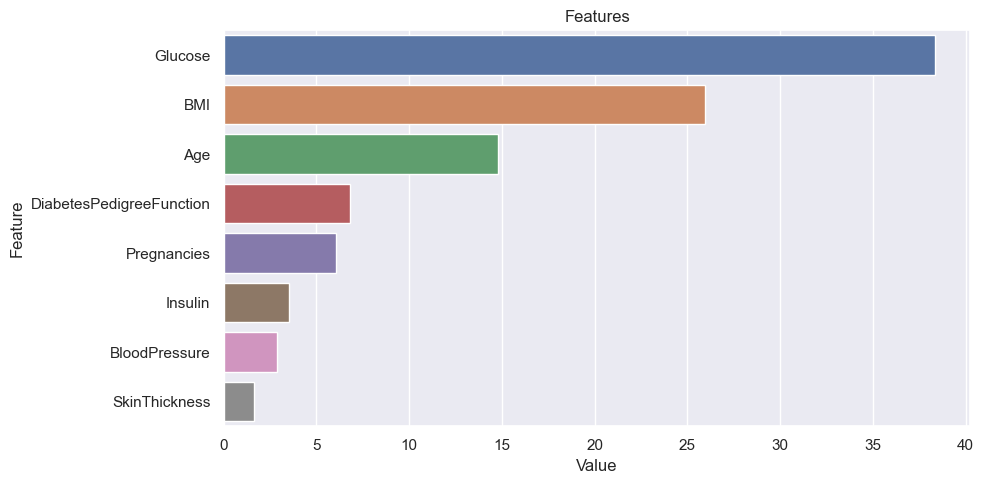

In [88]:
plot_importance(catboost_final, X)

## Hyperparameter Optimization with RandomSearchCV

In [90]:
rf_model = RandomForestClassifier(random_state=17)

In [91]:
rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

In [94]:
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1).fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [95]:
rf_random.best_params_

{'n_estimators': 488,
 'min_samples_split': 16,
 'max_features': 'auto',
 'max_depth': 28}

In [97]:
rf_random_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

In [98]:
cv_results = cross_validate(rf_random_final, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])

In [100]:
cv_results['test_accuracy'].mean()

0.7656990068754774

In [101]:
cv_results['test_f1'].mean()

0.6238654052187411

In [102]:
cv_results['test_roc_auc'].mean()

0.835587002096436

## Analyzing Model Complexity with Learning Curves

In [108]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [109]:
rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]

In [110]:
rf_model = RandomForestClassifier(random_state=17)

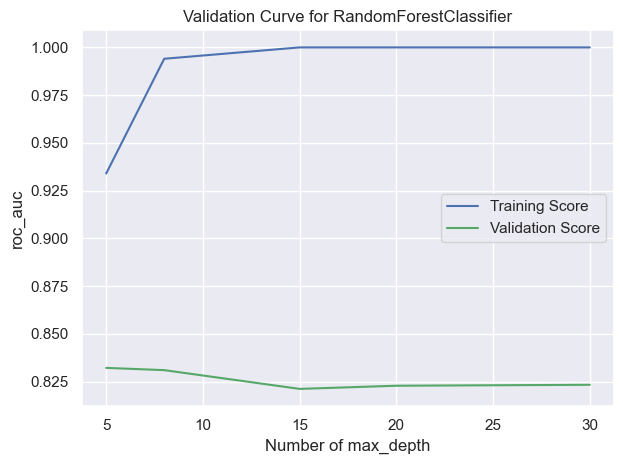

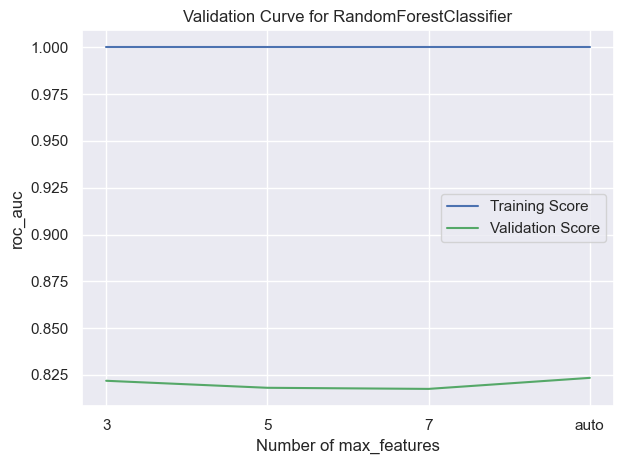

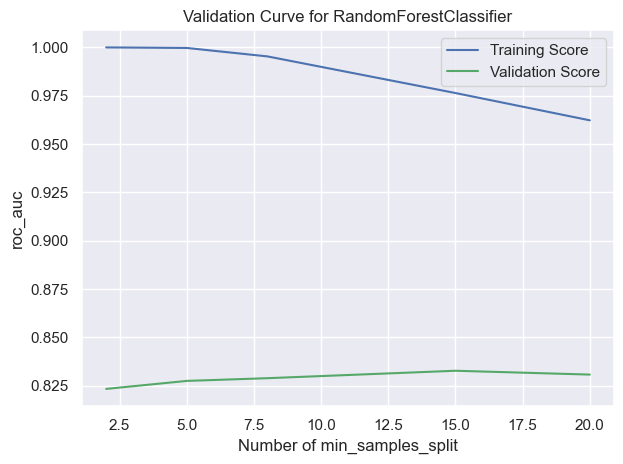

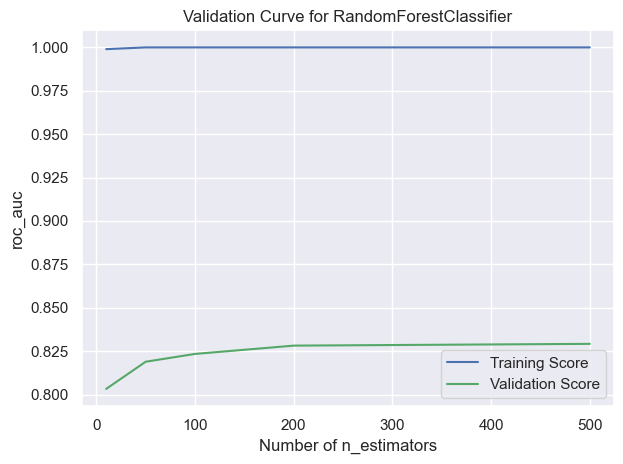

In [111]:
for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])